# Evaluating the Practical Limits of Zero-Noise Extrapolation in NISQ Devices

This notebook contains the experimental code used to study the behavior of
Zero-Noise Extrapolation (ZNE) applied to a Variational Quantum Eigensolver (VQE).
We begin by establishing a noiseless baseline before introducing noise and
error mitigation.

In [4]:
paulis = ["ZI", "IZ", "ZZ"]
coeffs = [1.0, 1.0, 0.5]

In [5]:
def ansatz(params):
    qc = QuantumCircuit(2)
    qc.ry(params[0], 0)
    qc.ry(params[1], 1)
    qc.cz(0, 1)
    return qc

In [6]:
def expectation_value(pauli, params, backend, shots):
    qc = ansatz(params)

    if pauli == "ZI":
        qc.measure_all()
    elif pauli == "IZ":
        qc.measure_all()
    elif pauli == "ZZ":
        qc.measure_all()

    job = backend.run(qc, shots=shots)
    counts = job.result().get_counts()

    exp = 0
    for bitstring, count in counts.items():
        value = 1
        for i, p in enumerate(pauli):
            if p == "Z" and bitstring[::-1][i] == "1":
                value *= -1
        exp += value * count

    return exp / shots


In [7]:
def energy(params, backend, shots):
    E = 0
    for p, c in zip(paulis, coeffs):
        E += c * expectation_value(p, params, backend, shots)
    return E

In [8]:
backend = AerSimulator()
shots = 99
energies = []

def callback(xk):
    energies.append(energy(xk, backend, shots))

res = minimize(
    energy,
    x0=[0.1, 0.1],
    args=(backend, shots),
    method="COBYLA",
    callback=callback,
    options={"maxiter": 50}
)

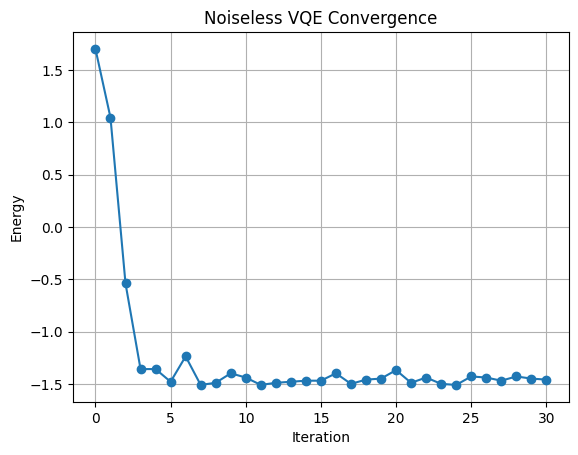

In [9]:
plt.plot(energies, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("Noiseless VQE Convergence")
plt.grid()
plt.show()

In [10]:
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(
    depolarizing_error(0.01, 1), ["ry"]
)

backend_noisy = AerSimulator(noise_model=noise_model)

In [11]:
shots = 99
energies_noisy = []

def callback_noisy(xk):
    energies_noisy.append(energy(xk, backend_noisy, shots))

res_noisy = minimize(
    energy,
    x0=[0.1, 0.1],
    args=(backend_noisy, shots),
    method="COBYLA",
    callback=callback_noisy,
    options={"maxiter": 50}
)

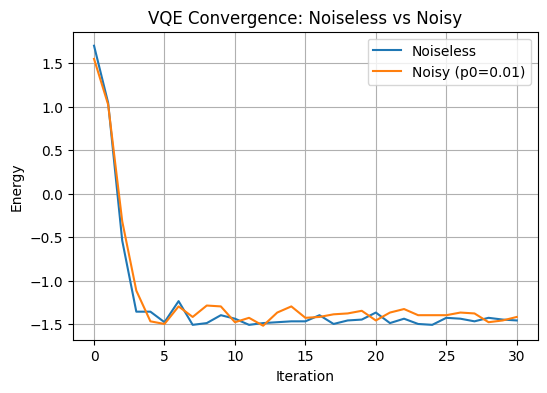

In [12]:
plt.figure(figsize=(6,4))
plt.plot(energies, label="Noiseless")
plt.plot(energies_noisy, label="Noisy (p0=0.01)")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("VQE Convergence: Noiseless vs Noisy")
plt.legend()
plt.grid()
plt.show()

In [13]:
def zne_energy(params, p0, shots_total):
    scales = [1, 2, 3]
    energies_scaled = []
    shots_per_scale = shots_total // len(scales)

    for s in scales:
        noise_model = NoiseModel()
        noise_model.add_all_qubit_quantum_error(
            depolarizing_error(p0 * s, 1), ["ry"]
        )
        backend = AerSimulator(noise_model=noise_model)
        E = energy(params, backend, shots_per_scale)
        energies_scaled.append(E)

    coeffs = np.polyfit(scales, energies_scaled, 1)
    return coeffs[-1]  # extrapolated zero-noise value

In [14]:
energies_zne = []

def callback_zne(xk):
    energies_zne.append(zne_energy(xk, p0=0.01, shots_total=99))

res_zne = minimize(
    zne_energy,
    x0=[0.1, 0.1],
    args=(0.01, 99),
    method="COBYLA",
    callback=callback_zne,
    options={"maxiter": 50}
)

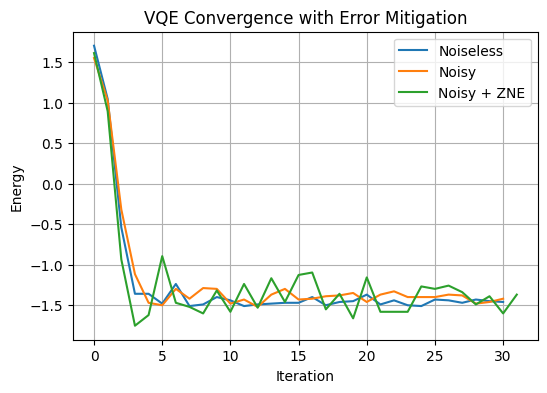

In [15]:
plt.figure(figsize=(6,4))
plt.plot(energies, label="Noiseless")
plt.plot(energies_noisy, label="Noisy")
plt.plot(energies_zne, label="Noisy + ZNE")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("VQE Convergence with Error Mitigation")
plt.legend()
plt.grid()
plt.show()